# Import packages

### Import python packages

In [1]:
import re,os
os.environ["CUDA_VISIBLE_DEVICES"]="7"
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from IPython.display import clear_output
import pandas as pd
import math
import random
from datetime import datetime
from scipy.stats import linregress
from sklearn.decomposition import PCA
from tqdm import trange, tqdm
from mpl_toolkits.mplot3d import Axes3D
import plotly.express as px
import plotly.graph_objects as go
from sklearn.manifold import TSNE
import scipy
from scipy import interpolate
tfk = tf.keras
tfkl = tf.keras.layers
clear_output()

### Import custom packages

In [2]:
from MRA_generate import MRA_generate
from symae_model import SymAE
from parameters import *
from redatuming import redatuming
from latent import latent
from plot_training import plot_training
from plot_redatuming import plot_redatuming
from plot_save import plot_save

Num GPUs Available:  1
TensorFlow Version:  2.9.1


# Generate dataset X

### Define $n_\varepsilon$ states

In [3]:
def g(n,x):
    return np.exp(-math.sqrt(n+1)*(x-0.5)**2)

Text(0.5, 0.98, 'Show the shape of all $n_\\epsilon$ = 50 states')

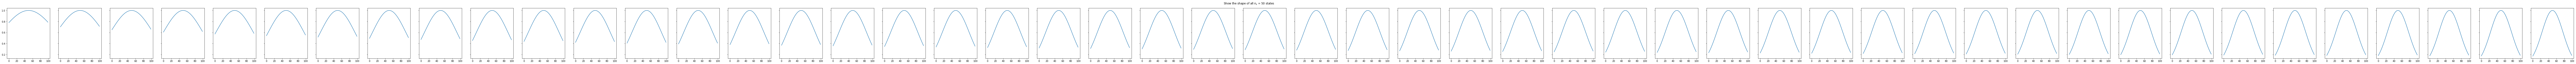

In [4]:
fig, axs = plt.subplots(1, ne, sharex=True, sharey=True, figsize=(ne*4, 4))
for i in range(ne):
    axs[i].plot(range(d), [g(i,x/d) for x in range(d)])
plt.suptitle('Show the shape of all $n_\epsilon$ = %d states'%ne)

### Generate the dataset

If replace==0, without replacement everywhere. Must $n_x*n_t <= n_\varepsilon*d$ and $n_t <= d$.  
If replace==1, X[i,:] have different nuisances, but each block in D can appear multiple times in X.  
If replace==2, with replacement everywhere.  
The default is replace=1.

In [5]:
MRA_training = MRA_generate(d,nt,N,sigma,ne,g,replace=0,continuous=True)

In [6]:
MRA_training.generate_default()
X = MRA_training.X

100%|███████████████████████████████████████| 1000/1000 [00:12<00:00, 82.97it/s]


In [7]:
states = MRA_training.states
shifts = MRA_training.shifts

### Print the structure of dataset X

Plot how many times each block in D appears in X

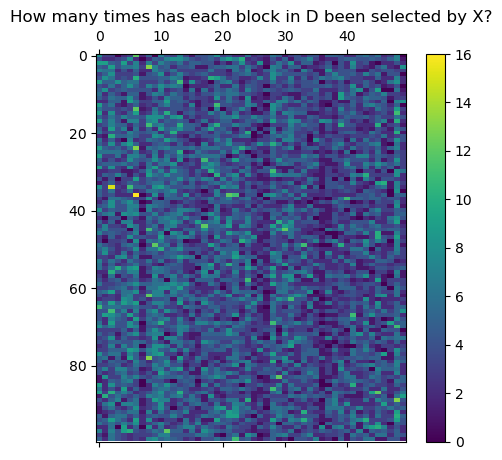

In [8]:
select_times = MRA_training.select_times
plt.figure(figsize=(5,5),dpi=100)
plt.matshow(select_times.T, aspect='auto', fignum=1)
plt.colorbar()
plt.title('How many times has each block in D been selected by X?')
plt.show()

# Train SymAE

### Initialize SymAE and load weights

In [18]:
model = SymAE(N,nt,d,p,q,kernel_size,filters,dropout_rate)
#model.load_weights('./checkpoint/'+'p=%d,q=%d,ne=%d'%(p,q,ne))
clear_output()

In [19]:
model.latentcat.drop.rate = 0.5
model.latentcat.drop.stddev = 0.5

### Train the NeuralNet

M: how many epochs you use

In [20]:
MRA_pca = MRA_generate(d,nt,1000,sigma,ne,g,replace=0,continuous=True)
pca_cb = PCA(n_components=2)
MRA_pca.generate_default()
X = MRA_training.X
N_shifts = MRA_pca.shifts.reshape(-1,1)
N_states = np.repeat(MRA_pca.states,nt)
df_states = pd.DataFrame(N_states,columns=['state'])
df_shifts = pd.DataFrame(N_shifts,columns=['shift'])
clear_output()

In [21]:
X_tf = tf.convert_to_tensor(X, dtype=tf.float32)
states_tf = tf.convert_to_tensor(states, dtype=tf.float32)
shifts_tf = tf.convert_to_tensor(shifts, dtype=tf.float32)
X_flatten = tf.reshape(X, (-1,d))
print(X_flatten.shape)
def g_tf(n,x):
    return tf.exp(-1.0*(x-0.5)**2)

(20000, 100)


In [22]:
optimizer = tf.keras.optimizers.Adam(0.001)
mse = tf.keras.losses.MeanSquaredError()

In [23]:
def reconstruction_loss(model, x):
    x_hat = model(x, training=False)
    return mse(x, x_hat)
def synthesize(tem, state, shifts):
    for i in range(nt):
        shift = shifts[i]
        tem[0,i,:,0] = [g(state, ((k+shift)%d)/d) for k in range(d)]
    return tem
def redatuming_loss(model):
    sample_size = 10 # in N=1000
    global states, shifts
    subscripts = np.random.randint(0, N, sample_size)
    x1 = X[subscripts, :, :]
    real_states1 = states[subscripts]
    latent_states = model.encoder(x1)[:, 0:p]
    
    subscripts = np.random.randint(0, N, sample_size)
    x2 = X[subscripts, :, :]
    real_shifts2 = shifts[subscripts, :]
    latent_shifts = model.encoder(x2)[:, p:p+q*nt]
    
    synthetic = np.zeros((1,nt,d,1), dtype=np.float32)
    tem = tf.constant(0.0, dtype=tf.float32)
    for i_prime in range(sample_size):
        for i in range(sample_size):
            merger = tf.concat([latent_states[i_prime:i_prime+1, :], 
                                latent_shifts[i:i+1, :]],
                                axis=1)
            redatum = model.decoder(merger)
            synthetic = synthesize(synthetic, real_states1[i_prime], real_shifts2[i, :])
            tem += mse(redatum, synthetic)
    return tem/100.0

@tf.function
def train_step(model, x):
    with tf.GradientTape() as tape:
        loss1 = reconstruction_loss(model, x)
        loss2 = redatuming_loss(model)
        loss = loss2
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    return loss1,loss2

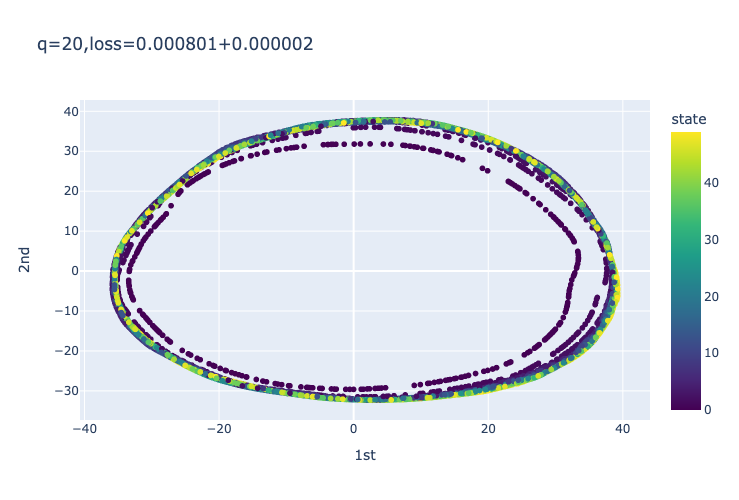

For epoch 105101, loss is 0.000825.
For epoch 105102, loss is 0.000803.
For epoch 105103, loss is 0.000826.
For epoch 105104, loss is 0.000802.
For epoch 105105, loss is 0.000827.
For epoch 105106, loss is 0.000802.
For epoch 105107, loss is 0.000827.
For epoch 105108, loss is 0.000802.
For epoch 105109, loss is 0.000829.
For epoch 105110, loss is 0.000800.
For epoch 105111, loss is 0.000831.
For epoch 105112, loss is 0.000798.
For epoch 105113, loss is 0.000835.
For epoch 105114, loss is 0.000794.
For epoch 105115, loss is 0.000839.
For epoch 105116, loss is 0.000792.
For epoch 105117, loss is 0.000843.
For epoch 105118, loss is 0.000792.
For epoch 105119, loss is 0.000844.
For epoch 105120, loss is 0.000791.
For epoch 105121, loss is 0.000845.
For epoch 105122, loss is 0.000791.
For epoch 105123, loss is 0.000844.
For epoch 105124, loss is 0.000790.
For epoch 105125, loss is 0.000844.
For epoch 105126, loss is 0.000791.
For epoch 105127, loss is 0.000841.
For epoch 105128, loss is 0.

KeyboardInterrupt: 

In [26]:
for epoch in range(1000000):
    loss1,loss2 = train_step(model, X_tf)
    print("For epoch {:d}, loss is {:f}.".format(epoch, loss1+loss2))
    if epoch % 50 == 0:
        clear_output(wait = True)
        _, Ns = latent(model,MRA_pca)
        N_reshaped = Ns.reshape(-1,q)
        pca_N = pca_cb.fit_transform(N_reshaped)
        df = pd.DataFrame(pca_N, columns = ['1st','2nd'])
        df = pd.concat([df,df_states,df_shifts],axis=1)
        fig = px.scatter(df, x='1st', y='2nd', color='state', 
                         text='shift', title='q=%d,loss=%f+%f'%(q,loss1,loss2), 
                         color_continuous_scale=px.colors.sequential.Viridis)
        fig.update_layout(height=500)
        fig.show()

### Save weights

In [27]:
#model.save_weights('./checkpoint/'+datetime.now().strftime("%B%d"))
model.save_weights('./checkpoint/'+'p=%d,q=%d,ne=%d'%(p,q,ne))
print("weights saved")

weights saved


### Save plot

In [ ]:
#plot_save(fig,ID=-1)

# Redatuming

In [28]:
def find(state,nuisance):
    '''
    Generate a dataset with N=1 and this specific state

    Parameters
    ----------
    state : int
        The state you want
        
    Returns
    ----------
    MRA_data : class MRA_generate
    '''
    MRA_data = MRA_generate(d,nt,1,sigma,ne,g,replace=1)
    for i in range(1000):
        MRA_data.generate_default()
        if MRA_data.states[0] != state:
            continue
        for j in range(nt):
            if MRA_data.shifts[0][j] == nuisance:
                return MRA_data, j

### Choose which 2 states and shifts you want to redatum 

In [29]:
MRA1, t1 = find(2,0)
MRA2, t2 = find(49,36)

### Redatuming and the visualize it

The MSE of C1N2 is: 0.023146
The MSE of C2N1 is: 0.145184


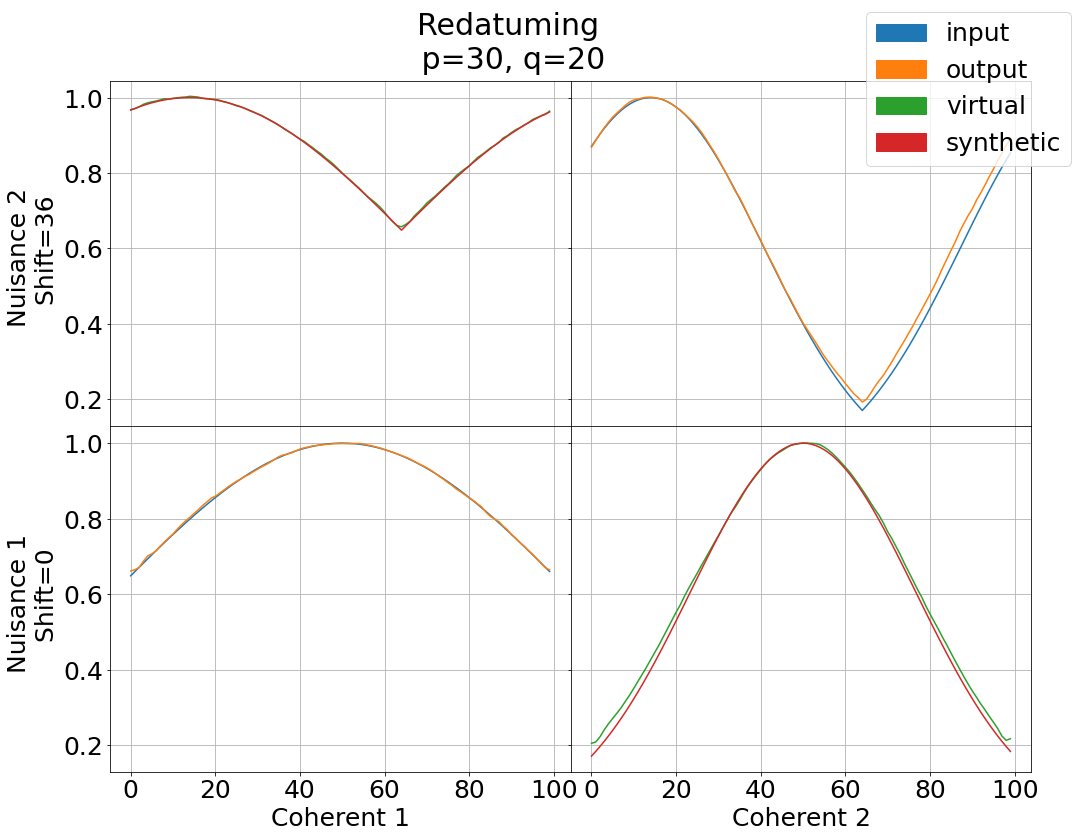

In [30]:
redatum = redatuming(model,MRA1,MRA2,t1,t2)
MSE_C1_N2, MSE_C2_N1 = redatum.MSE()
fig = plot_redatuming(redatum)
clear_output()
print('The MSE of C1N2 is: %f'%MSE_C1_N2)
print('The MSE of C2N1 is: %f'%MSE_C2_N1)

### Save redatuming plot

In [ ]:
plot_save(fig,ID=-1)

### List many redatuming

In [ ]:
def dec(latent_code):
    tem = latent_code[np.newaxis, np.newaxis, :]
    tem = np.repeat(tem, nt, axis=1)
    tem = model.mixer.predict(tem, verbose=0)
    return tem[0,0,:]
def enc(state, shift):
    tem = np.array( [g(state, ((k+shift)%d)/d) for k in range(d)] )
    tem = tem[np.newaxis, np.newaxis, :, np.newaxis]
    tem = np.repeat(tem, nt, axis=1)
    tem = model.encoder.predict(tem, verbose=0)
    return tem[0][0:p+q]

In [ ]:
state_source = 0
nuisance_source = 40
fig, axs = plt.subplots(1, d, sharex=True, sharey=True, figsize=(4*d,4), dpi=40)
for i in trange(d):
    coherent_code = enc(state_source, 0)[0: p]
    nuisance_code = enc(nuisance_source, i)[p: p+q]
    latent_code = np.concatenate([coherent_code, nuisance_code], axis=0)
    axs[i].plot(range(d), dec(latent_code))
    axs[i].set_title('%d'%i)
plt.suptitle('$\hat{X}_{s=%d \mapsto s=%d}$'%(nuisance_source, state_source), fontsize=50)
plt.subplots_adjust(top=0.6)
plt.show()
#fig.savefig('./plots/%dto%d'%(nuisance_source, state_source))

# Interpolation

In [ ]:
def dec(latent_code):
    tem = latent_code[np.newaxis, np.newaxis, :]
    tem = np.repeat(tem, nt, axis=1)
    tem = model.mixer.predict(tem, verbose=0)
    return tem[0,0,:]
def enc(state, shift):
    tem = np.array( [g(state, ((k+shift)%d)/d) for k in range(d)] )
    tem = tem[np.newaxis, np.newaxis, :, np.newaxis]
    tem = np.repeat(tem, nt, axis=1)
    tem = model.encoder.predict(tem, verbose=0)
    return tem[0][0:p+q]

### Set endpoints

In [ ]:
state = -1
shift1 = 0
shift2 = 30

In [ ]:
def g(n,x):
    if n==-1:
        return int(x<0.5)
    return np.exp(-math.sqrt(n+1)*(x-0.5)**2)

### Linear

In [ ]:
interpolation_number = L = 10
interpolation = np.empty((L,d))
for i, alpha in enumerate(range(L)):
    alpha = alpha / L
    code1 = enc(state, shift1)
    code2 = enc(state, shift2)
    code = alpha*code1 + (1-alpha)*code2
    interpolation[i:i+1,:] = dec(code).T
fig = plt.figure(figsize=(10,6))
for i, alpha in enumerate(range(L)):
    alpha = alpha / L
    plt.plot(range(d),interpolation[i,:], color=(alpha,0,1-alpha))
plt.grid()

### Cubic Spline

In [ ]:
class spline():
    def __init__(self, state):
        self.state = state
        self.x = np.arange(0, d, 1)
        self.y = np.empty((q, len(self.x)))
        self.tck = []
        self.center = enc(state, 0)[0:p]
        for j in trange(len(self.x)):
            l = self.x[j]
            latent_code = enc(state, l)
            for i in range(q):
                self.y[i,j] = latent_code[p+i]
        for i in range(q):
            self.tck.append(interpolate.splrep(self.x, self.y[i,:], per=True))
    def call(self, shift):
        return np.array([interpolate.splev(shift, self.tck[i], der=0) for i in range(q)])
    def call_batch(self, shifts):
        return np.array([[interpolate.splev(shift, self.tck[i], der=0) for i in range(q)] for shift in shifts])
    def decode(self, shift):
        return dec(np.hstack([self.center, self.call(shift)]))
    def decode_batch(self, shifts):
        return np.array([self.decode(shift) for shift in tqdm(shifts)])

In [ ]:
spline_obj = spline(state)

In [ ]:
spline_obj.decode_batch([5,6]).shape

In [ ]:
plt.plot(range(d), spline_obj.decode(5))

### By hand

In [ ]:
code1 = enc(state, shift1)
code2 = enc(state, shift2)
code = 0.5*code1 + 0.5*code2 + 1.0
interpolation = dec(code)
fig = plt.figure(figsize=(10,6))
plt.plot(range(d), [g(state, ((k+shift1)%d)/d) for k in range(d)], color=(1,0,0))
plt.plot(range(d), [g(state, ((k+shift2)%d)/d) for k in range(d)], color=(0,0,1))
plt.plot(range(d),interpolation, color=(1,0,1))
plt.grid()

### PCA

In [ ]:
pca = PCA(2)
Ns = np.empty((100,q))
for i in trange(100):
    shift = i
    Ns[i,:] = enc(state, shift)[p:p+q]

In [ ]:
pca_N = pca.fit_transform(Ns)
pca_N1 = pca.transform(code1[np.newaxis, p:p+q])
pca_N2 = pca.transform(code2[np.newaxis, p:p+q])
pca_N_hand = pca.transform(code[np.newaxis, p:p+q])
pca_N_spline = pca.transform(spline_obj.call_batch(np.arange(0,100,0.1)))

In [ ]:
data0 = go.Scatter(x=pca_N[:,0], y=pca_N[:,1], mode='markers', name='dataset')
data1 = go.Scatter(x=pca_N1[:,0], y=pca_N1[:,1], mode='markers', marker=dict(color='rgb(255, 0, 0)'), name='endpoint1')
data2 = go.Scatter(x=pca_N2[:,0], y=pca_N2[:,1], mode='markers', marker=dict(color='rgb(255, 0, 0)'), name='endpoint2')
data_line = go.Scatter(x=[pca_N1[0,0],pca_N2[0,0]], y=[pca_N1[0,1],pca_N2[0,1]], marker=dict(color='rgb(255, 200, 0)'), name='line')
data_hand = go.Scatter(x=pca_N_hand[:,0], y=pca_N_hand[:,1], mode='markers', marker=dict(color='rgb(150, 255, 150)'), name='hand')
data_spline = go.Scatter(x=pca_N_spline[:,0], y=pca_N_spline[:,1], marker=dict(color='rgb(200, 50, 200)'), name='spline')
fig = go.Figure(data=[data0,data_line,data1,data2,data_hand,data_spline])
fig.update_layout(height=600)
fig.show()

In [ ]:
pca = PCA(n_components=3)
MRA_pca = MRA_generate(d,nt,1000,sigma,ne,g,replace=1)
MRA_pca.generate_default()
Cs,Ns = latent(model,MRA_pca)

In [ ]:
pca.fit(Cs)
pca_C = pca.fit_transform(Cs)
df = pd.DataFrame(pca_C, columns = ['1st','2nd','3rd'])
tem = pd.DataFrame(MRA_pca.states,columns=['state']).astype('object')
df = pd.concat([df,tem],axis=1)
fig = px.scatter_3d(df, x='1st', y='2nd', z='3rd', color='state')
fig.show()

In [ ]:
state = 0
N_reshaped = Ns[MRA_pca.states==state,:].reshape(-1,q) 
N_shifts = MRA_pca.shifts[MRA_pca.states==state,:].reshape(-1,1)
pca = PCA(n_components=3)
pca.fit(N_reshaped)
pca_N = pca.fit_transform(N_reshaped)
df = pd.DataFrame(pca_N, columns = ['1st','2nd','3rd'])
tem = pd.DataFrame(N_shifts,columns=['shift'])
df = pd.concat([df,tem],axis=1)
fig = px.scatter_3d(df, x='1st', y='2nd', z='3rd', color='shift')
fig.show()

p-space is another name of the latent coherent space

In [ ]:
pca_C = pca.fit_transform(Cs)
center = np.empty((ne,2))
fig = plt.figure(figsize=(5,4),dpi=100)
for i in range(ne):
    center[i,:] = sum(pca_C[MRA_pca.states==i,:])/sum(MRA_pca.states==i)
    plt.text(center[i,0],center[i,1],"state=%d"%i,fontsize=15)
for i in trange(1000):
    plt.scatter(pca_C[i,0],pca_C[i,1],color='C%d'%(MRA_pca.states[i]))
plt.title('PCA of p-space',fontsize=15)
plt.tick_params(labelsize=15)
plt.tight_layout()